## Importing Required Packages

In [107]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

## Downloading Data

In [70]:
main_root = tf.keras.utils.get_file('cats_and_dogs.zip', 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', extract=True)

## Organizing Data in Folders

In [71]:
base_dir = os.path.join(os.path.dirname(main_root), "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

In [72]:
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

## Defining Data Augmentation Function

In [73]:
def augment_data(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize_with_crop_or_pad(image, 180, 180)
  image = tf.image.random_crop(image, size=(150, 150, 3))
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image

## Defining Class Names

In [90]:
class_names = np.array([item for item in os.listdir(train_dir)])
class_names

array(['dogs', 'cats'], dtype='<U4')

## Defining Train and Validation Datasets

In [75]:
train_dataset = tf.data.Dataset.list_files(f"{train_dir}/*/*")
validation_dataset = tf.data.Dataset.list_files(f"{validation_dir}/*/*")

## Defining Get Label Function


In [76]:
def get_label(image_path):
  parts = tf.strings.split(image_path, os.path.sep)
  return parts[-2] == class_names

## Defining Load Image Function

In [77]:
def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image, 3, expand_animations=False)
  image = tf.cast(image, tf.float32)
  return image

## Defining Resize Image Function

In [78]:
def resize_image(image, height, width):
  image = tf.image.resize(image, (height, width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

## Defining Data Normalization Function

In [79]:
def normalize_data(image):
  return image / 255

## Defining Load Image with Label Function

In [80]:
def load_image_with_label(image_path):
  image = load_image(image_path)
  label = get_label(image_path)
  return image, label

## Defining Load Image Train Function

In [81]:
def load_image_train(image_path):
  image, label = load_image_with_label(image_path)
  image = augment_data(image)
  image = normalize_data(image)
  return image, label

## Defining Load Image Test Function

In [82]:
def load_image_test(image_path):
  image, label = load_image_with_label(image_path)
  image = resize_image(image, 150 , 150)
  image = normalize_data(image)
  return image, label

## Setting Train and Validation Datset Options

In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [84]:
validation_dataset = validation_dataset.map(load_image_test)
validation_dataset = validation_dataset.batch(32)

## Building ConvBase Model

In [109]:
conv_base = VGG16(include_top=False, weights="imagenet", input_shape=(150, 150, 3))

In [110]:
conv_base.trainable = False
for layer in conv_base.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True

## Building Model

In [111]:
model = Sequential([conv_base,
                    layers.Flatten(),
                    layers.Dense(256, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.5),
                    layers.Dense(len(class_names), activation="softmax")])

In [112]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 514       
                                                      

## Compiling the Model

In [113]:
optimizer = RMSprop(learning_rate=1e-5)
model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

## Fitting the Model

In [114]:
h = model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 9s 107ms/step - loss: 0.9524 - accuracy: 0.5545 - val_loss: 0.7361 - val_accuracy: 0.5390
Epoch 2/100
63/63 [==============================] - 8s 108ms/step - loss: 0.8071 - accuracy: 0.6120 - val_loss: 0.7017 - val_accuracy: 0.5880
Epoch 3/100
63/63 [==============================] - 8s 100ms/step - loss: 0.6907 - accuracy: 0.6815 - val_loss: 0.6927 - val_accuracy: 0.6270
Epoch 4/100
63/63 [==============================] - 8s 111ms/step - loss: 0.6419 - accuracy: 0.7050 - val_loss: 0.6416 - val_accuracy: 0.6740
Epoch 5/100
63/63 [==============================] - 8s 116ms/step - loss: 0.6126 - accuracy: 0.7305 - val_loss: 0.6169 - val_accuracy: 0.7110
Epoch 6/100
63/63 [==============================] - 8s 110ms/step - loss: 0.5522 - accuracy: 0.7555 - val_loss: 0.5992 - val_accuracy: 0.7260
Epoch 7/100
63/63 [==============================] - 9s 105ms/step - loss: 0.5304 - accuracy: 0.7555 - val_loss: 0.5619 - val_accuracy: 0.7520

## Evaluating the Model

In [115]:
model.evaluate(validation_dataset)

32/32 [==============================] - 2s 64ms/step - loss: 0.4266 - accuracy: 0.8500


[0.4265700578689575, 0.8500000238418579]

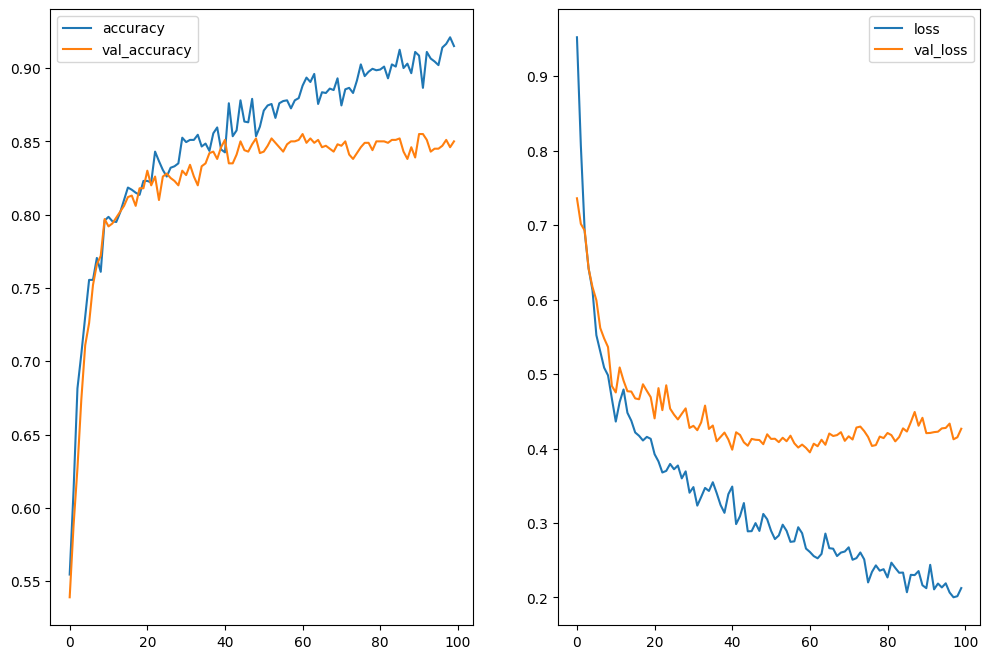

In [116]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(h.history["accuracy"], label="accuracy")
plt.plot(h.history["val_accuracy"], label="val_accuracy")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(h.history["loss"], label="loss")
plt.plot(h.history["val_loss"], label="val_loss")
plt.legend(loc="best")
plt.show()